# Training a classifier on the event-based POKER-DVS dataset

When working with Spiking Neural Networks (SNN), we will inevitably encounter the notion of _time_ in our network and data flow. The classic example of MNIST handwritten digits consists of images, much like snapshots in time. Deep learning has shown impressive results on such purely spatial compositions, but SNNs might be able to extract meaning from temporal features and/or save power doing so in comparison to classical networks. 

An event camera such as the Dynamic Vision Sensor (DVS) is [somewhat based](https://medium.com/@gregorlenz/rethinking-the-way-our-cameras-see-8584b5167bb) on the functional principle of the human retina. Such a camera can record a scene much more efficiently than a conventional camera by encoding the changes in a visual scene rather than absolute illuminance values. The output is a spike train of change detection events for each pixel. While previously we had to use encoders to equip static image data with a temporal dimension, the POKER-DVS dataset contains recordings of poker cards that are shown to an event camera in rapid succession.

**Warning!** This notebook uses a large dataset and can take a significant amount of time to execute.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

We can simply install Norse through pip:

In [2]:
%pip install norse --quiet

Note: you may need to restart the kernel to use updated packages.


For this tutorial we are going to make use of a package that handles event-based datasets called [Tonic](https://github.com/neuromorphs/tonic). It is based on PyTorch Vision, so you should already have most of its dependencies installed.

In [3]:
%pip install tonic --quiet

Note: you may need to restart the kernel to use updated packages.


Let's start by loading the POKER-DVS dataset and specifying a sparse tensor transform whenever a new sample is loaded

In [4]:
import tonic
import torchvision

sensor_size = tonic.datasets.POKERDVS.sensor_size
frame_transform = tonic.transforms.ToFrame(sensor_size=sensor_size, time_window=1000)

trainset = tonic.datasets.POKERDVS(save_to='./data', train=True)
testset = tonic.datasets.POKERDVS(save_to='./data', transform=frame_transform, train=False)

We can have a look at how a sample of one digit looks like. The event camera's output is encoded as events that have x/y coordinates, a timestamp and a polarity that indicates whether the lighting increased or decreased at that event. The events are provided in an (NxE) array. Let's have a look at the first example in the dataset. Every row in the array represents one event of timestamp, x, y, and polarity.

In [5]:
events = trainset[0][0]
events

array([(    0,  7, 22, 1), (   16, 19, 13, 0), (   18, 24, 23, 1), ...,
       (14239, 21, 16, 1), (14246, 24, 14, 1), (14247, 14, 14, 1)],
      dtype=[('t', '<i4'), ('x', '<i4'), ('y', '<i4'), ('p', '<i4')])

When accumulated over time into 3 bins, the images show 1 of 4 card symbols

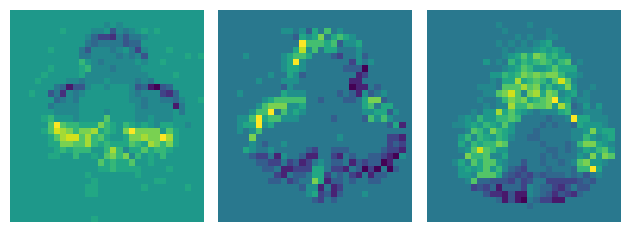

In [6]:
tonic.utils.plot_event_grid(events)

And this one is the target class:

In [7]:
trainset[0][1]

0

We wrap the training and testing sets in PyTorch DataLoaders that facilitate file loading. Note also the custom collate function __pad_tensors__ , which makes sure that all sparse tensors in the batch have the same dimensions

In [8]:
# reduce this number if you run out of GPU memory
BATCH_SIZE = 32

# add sparse transform to trainset, previously omitted because we wanted to look at raw events
trainset.transform = frame_transform

train_loader = torch.utils.data.DataLoader(trainset,
                                        batch_size=BATCH_SIZE,
                                        collate_fn=tonic.collation.PadTensors(batch_first=False),
                                        shuffle=True
)

test_loader = torch.utils.data.DataLoader(testset,
                                        batch_size=BATCH_SIZE,
                                        collate_fn=tonic.collation.PadTensors(batch_first=False),
                                        shuffle=False
)

## Defining a Network

Once the data is encoded into spikes, a spiking neural network can be constructed in the same way as a one would construct a recurrent neural network.
Here we define a spiking neural network with one recurrently connected layer
with `hidden_features` LIF neurons and a readout layer with `output_features` and leaky-integrators. As you can see, we can freely combine spiking neural network primitives with ordinary `torch.nn.Module` layers.

In [9]:
from norse.torch.module.lif import LIFCell, LIFParameters, LIFState
from norse.torch.module.leaky_integrator import LICell, LIState
from norse.torch import LIFRecurrentCell
# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)


from typing import NamedTuple

class SNNState(NamedTuple):
    lif0 : LIFState
    readout : LIState


class SNN(torch.nn.Module):
    def __init__(self, input_features, hidden_features, output_features, tau_syn_inv, tau_mem_inv, record=False, dt=1e-3):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, 
                            v_th=torch.as_tensor(0.3),
                            tau_syn_inv=tau_syn_inv,
                            tau_mem_inv=tau_mem_inv,
                           ),
            dt=dt                     
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
              LIFState(
                z = torch.zeros(seq_length, batch_size, self.hidden_features),
                v = torch.zeros(seq_length, batch_size, self.hidden_features),
                i = torch.zeros(seq_length, batch_size, self.hidden_features)
              ),
              LIState(
                v = torch.zeros(seq_length, batch_size, self.output_features),
                i = torch.zeros(seq_length, batch_size, self.output_features)
              )
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts,:] = s1.z
                self.recording.lif0.v[ts,:] = s1.v
                self.recording.lif0.i[ts,:] = s1.i
                self.recording.readout.v[ts,:] = so.v
                self.recording.readout.i[ts,:] = so.i
            voltages += [vo]

        return torch.stack(voltages)

It's a good idea to test the network's response to time constant parameters that depend on the duration of recordings in the dataset as well as average number of events. We use dt=1e-6 because the events we're dealing with have microsecond resolution

In [10]:
example_snn = SNN(np.product(trainset.sensor_size), 100, len(trainset.classes), tau_syn_inv=torch.tensor(1/1e-2), tau_mem_inv=torch.tensor(1/1e-2), record=True, dt=1e-3)

frames, target = next(iter(train_loader))

frames[:,:1].shape

torch.Size([29, 1, 2, 35, 35])

Note that we are only applying a subset (`1000`) of the data timesteps (`22227`).

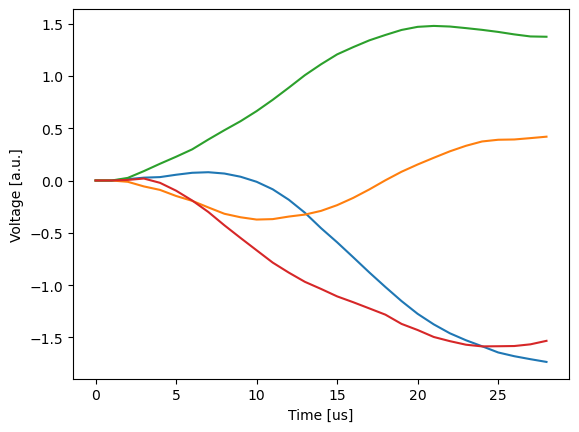

In [11]:
example_readout_voltages = example_snn(frames[:,:1])
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel('Voltage [a.u.]')
plt.xlabel('Time [us]')
plt.show()

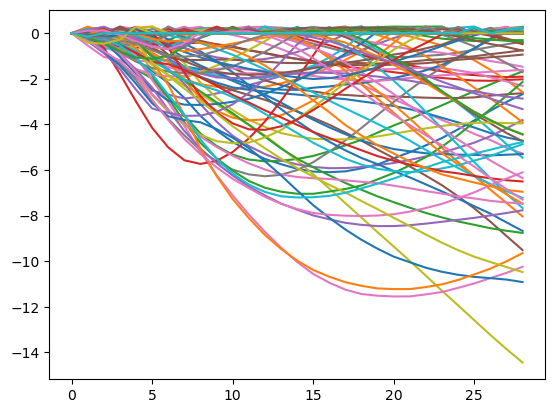

In [12]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

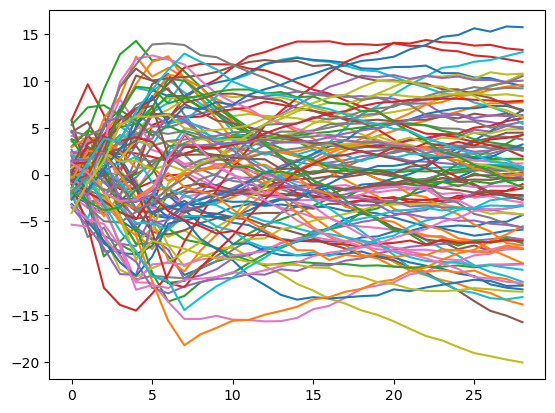

In [13]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

## Training the Network

The final model is then simply the sequential composition of our network and a decoding step.

In [14]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

class Model(torch.nn.Module):
    def __init__(self, snn, decoder):
        super(Model, self).__init__()
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [15]:
LR = 0.002
INPUT_FEATURES = np.product(trainset.sensor_size)
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = len(trainset.classes)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    snn=SNN(
      input_features=INPUT_FEATURES,
      hidden_features=HIDDEN_FEATURES,
      output_features=OUTPUT_FEATURES,
      tau_syn_inv=torch.tensor(1/1e-2), 
      tau_mem_inv=torch.tensor(1/1e-2)
    ),
    decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=2450, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(100.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.3000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=4, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

What remains to do is to setup training and test code. This code is completely independent of the fact that we are training a spiking neural network and in fact has been largely copied from the pytorch tutorials.

In [16]:
from tqdm.notebook import tqdm, trange


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), torch.LongTensor(target).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

Just like the training function, the test function is standard boilerplate, common with any other supervised learning task.

In [17]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), torch.LongTensor(target).to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [18]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

torch.autograd.set_detect_anomaly(True)

EPOCHS  = 10

for epoch in trange(EPOCHS):
    training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch)
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

print(f"final accuracy: {accuracies[-1]}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

final accuracy: 100.0


We can visualize the output of the trained network on an example input

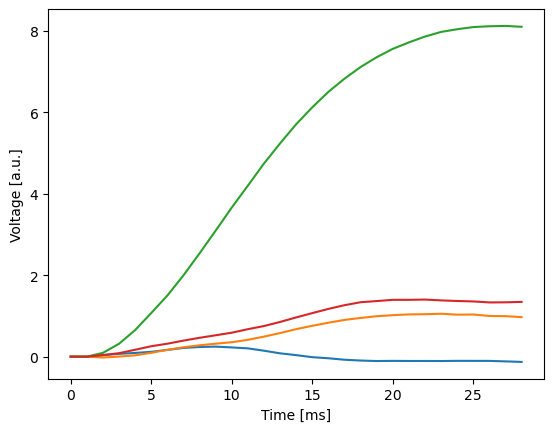

In [20]:
trained_snn = model.snn
trained_readout_voltages = trained_snn(frames[:,:1].to("cpu"))
plt.plot(trained_readout_voltages.squeeze(1).cpu().detach().numpy())

plt.ylabel('Voltage [a.u.]')
plt.xlabel('Time [ms]')
plt.show()

: 